## Musinsa Customal's Viewpoint - Brand Ranking

    작성자 : 조예슬
    
    소비자들의 조회수, 판매수가 높을 수록 관심이 높다고 판단
    브랜드 랭킹이 소비자 관심에 미치는 영향은 어떤지 알아보기
    
    - MySQL을 이용하여 데이터 전처리 진행
    - 브랜드 랭킹에 따라 상품들의 조회수, 판매수 평균 내고, 시각화 시키기

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt                                                 # 실제로 그래프를 그려주는 애
import seaborn as sns

import matplotlib.font_manager as fm                                            # 한글폰트 안깨져서 나오게하기위해
font_name = fm.FontProperties(fname="C:\Windows/Fonts/malgun.ttf").get_name()    # 폰트 지정
plt.rc('font', family=font_name)                                                 # matplotlib내에 폰트 설정

mpl.rcParams["axes.unicode_minus"] = False        # 음수 설정, False로 지정하면 음수를 문자로 쓰지않고 숫자로 지정하겠다는 의미, 음수로 사용이 가능해진다.

import MySQLdb

In [3]:
config = {"host":"192.168.0.31", "user":"musinsa", "password":"1111", "database":"PR_TEST", "charset":'utf8'}
conn = MySQLdb.connect(**config)

In [40]:
# 브랜드 랭킹 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT BR.RANK_RANGE, BR.RANK_SORT, BR.BRD_RANK, BR.BRD_CODE, BR.LOAD_DATE
FROM BRAND_RANK BR
WHERE RANK_RANGE = "1d" AND RANK_SORT = "pop";"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

rank_columns = ["RANK_RANGE", "RANK_SORT", "BRD_RANK", "BRD_CODE", "LOAD_DATE"]

RANK= pd.DataFrame(arr, columns=rank_columns)

# string -> float
RANK["BRD_RANK"] = RANK["BRD_RANK"].astype(float)

RANK.head(5)

,RANK_RANGE,RANK_SORT,BRD_RANK,BRD_CODE,LOAD_DATE
0,1d,pop,1.0,musinsastandard,2020-01-12 23:43:42
1,1d,pop,2.0,covernat,2020-01-12 23:43:42
2,1d,pop,3.0,adidas,2020-01-12 23:43:42
3,1d,pop,4.0,thisisneverthat,2020-01-12 23:43:42
4,1d,pop,5.0,nike,2020-01-12 23:43:42


In [6]:
# RANK 평균 나타내기
RANK_MEAN = (RANK.groupby(RANK.BRD_CODE).mean()).round(2)
RANK_MEAN.head(5)

,BRD_RANK
BRD_CODE,
1507,77.43
2365,99.00
247seoul,74.71
5252byoioi,49.29
86road,73.71


In [7]:
# BRAND_LIST 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT BL.BRD_NAME_ENG, BL.BRD_CODE
FROM BRAND_LIST BL;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

BLIST_columns = ["BRD_NAME", "BRD_CODE"]

BLIST= pd.DataFrame(arr, columns=BLIST_columns)

BLIST.head(10)


,BRD_NAME,BRD_CODE
0,AAC,doubleac
1,AGNEL,agnel
2,ACOTEDEMOI,acotedemoi
3,ANATECH,anatech
4,ANALOG MOOD,analogmood
5,AGNESB,agnesbeyewear
6,ANELLO,anello
7,ANONIMO-A,anonimoa
8,ANOMIE COMPLEX,anomiecomplex
9,ANOBLIR,anoblir


In [8]:
# PRDT_INFO 데이터 전처리 

cursor = conn.cursor()  

sql = """SELECT P.BRD_NAME_KOR, P.PRDT_CODE
FROM PRDT_INFO P;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

PINFO_columns = ["BRD_NAME", "PRDT_CODE"]

PINFO= pd.DataFrame(arr, columns=PINFO_columns)

PINFO.head(5)


,BRD_NAME,PRDT_CODE
0,ROMANTIC CROWN,1149744
1,THISISNEVERTHAT,960950
2,CARHARTT,1220317
3,DIAMOND LAYLA,1150429
4,WKNDRS,713621


In [9]:
# 상품별 조회수, 구매수 데이터 전처리 
cursor = conn.cursor()  

sql = """SELECT PPV.PRDT_CODE, PPV.VIEW_CNT, PPC.PUR_CNT
FROM PRDT_PAGEVIEW PPV INNER JOIN PRDT_PURCHASE PPC
ON PPV.PRDT_CODE = PPC.PRDT_CODE;"""
                      
cursor.execute(sql) 

arr = cursor.fetchall()

PRDT_VP_columns = ["PRDT_CODE", "VIEW_CNT", "PUR_CNT"]

PRDT_VP= pd.DataFrame(arr, columns=PRDT_VP_columns)

# string -> float
PRDT_VP["VIEW_CNT"] = PRDT_VP["VIEW_CNT"].astype(float)
PRDT_VP["PUR_CNT"] = PRDT_VP["PUR_CNT"].astype(float)

PRDT_VP.head(5)

,PRDT_CODE,VIEW_CNT,PUR_CNT
0,1000048,1363.0,308.0
1,1000112,983.0,149.0
2,1000149,136.0,41.0
3,1000153,561.0,42.0
4,1000154,209.0,43.0


In [10]:
B_R_L = pd.merge(RANK_MEAN, BLIST, on="BRD_CODE", how="outer")
B_R_L.head(5)

,BRD_CODE,BRD_RANK,BRD_NAME
0,1507,77.43,IL-O-GONG-CHIL
1,2365,99.00,23.65
2,247seoul,74.71,247 SEOUL
3,5252byoioi,49.29,5252BYOIOI
4,86road,73.71,86ROAD


In [11]:
# BRAND 상품들 조회수, 판매수 평균내기

BRAND_VP = pd.merge(PINFO, PRDT_VP, on = "PRDT_CODE", how="outer")

B_VP_MEAN = BRAND_VP.groupby("BRD_NAME").mean().round(2)
B_VP_MEAN.fillna(0, inplace=True)
B_VP_MEAN.head(10)

,VIEW_CNT,PUR_CNT
BRD_NAME,,
,0.00,0.00
(407)HAUS,0.00,0.00
090FACTORY,0.00,0.00
1'SOFT,1121.00,0.00
100%,31.00,0.00
1000V,0.00,0.00
108SEOUL,62.05,4.37
1159STUDIO,299.25,0.00
12,0.00,0.00


In [12]:
Total = pd.merge(B_R_L, B_VP_MEAN, on = "BRD_NAME")
Total.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
75,musinsastandard,1.00,MUSINSA STANDARD,9669.08,156338.74
25,covernat,2.29,COVERNAT,9042.19,0.00
8,adidas,3.29,ADIDAS,7218.45,47717.26
80,nike,5.43,NIKE,2392.77,305.66
107,thisisneverthat,5.57,THISISNEVERTHAT,5179.60,0.00


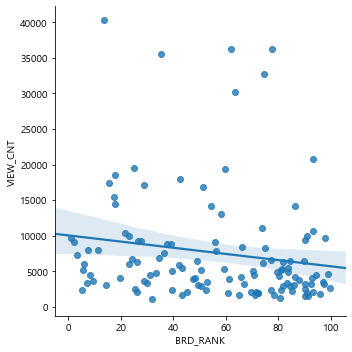

In [13]:
# 브랜드 랭킹에 따른 조회수 시각화
sns.lmplot(x = "BRD_RANK", y = "VIEW_CNT", data = Total)

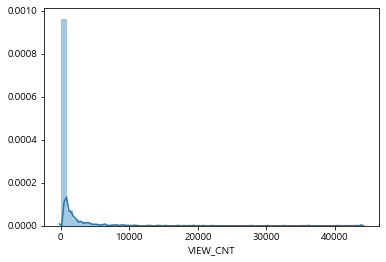

In [15]:
# 브랜드 랭킹에 따른 조회수 시각화 : 정규분포
sns.distplot(Total["VIEW_CNT"])

In [16]:
# 정규분포 보고 버릴건 버리자 VIEW_CNT : 40000 -> 13000
Total_V = Total.loc[Total["VIEW_CNT"] < 13000]
Total_V.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
75,musinsastandard,1.00,MUSINSA STANDARD,9669.08,156338.74
25,covernat,2.29,COVERNAT,9042.19,0.00
8,adidas,3.29,ADIDAS,7218.45,47717.26
80,nike,5.43,NIKE,2392.77,305.66
107,thisisneverthat,5.57,THISISNEVERTHAT,5179.60,0.00


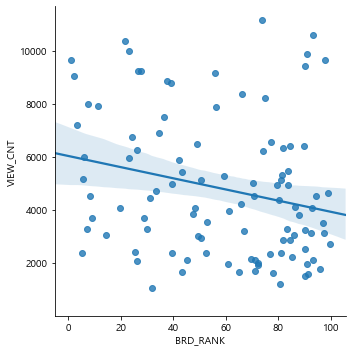

In [17]:
# 브랜드 랭킹에 따른 조회수 시각화 : VIEW_CNT : 40000 -> 13000
sns.lmplot(x = "BRD_RANK", y = "VIEW_CNT", data = Total_V)

In [18]:
# 랭킹 구간별로 나눠보기 : RANK : 0 - 50
Total_V2 = Total_V.loc[Total_V["BRD_RANK"] < 50]
Total_V2.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
75,musinsastandard,1.00,MUSINSA STANDARD,9669.08,156338.74
25,covernat,2.29,COVERNAT,9042.19,0.00
8,adidas,3.29,ADIDAS,7218.45,47717.26
80,nike,5.43,NIKE,2392.77,305.66
107,thisisneverthat,5.57,THISISNEVERTHAT,5179.60,0.00


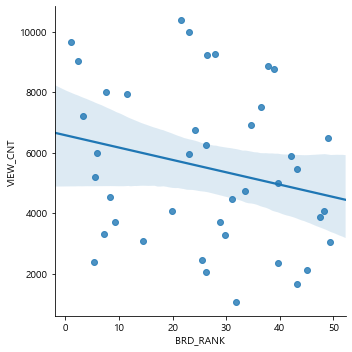

In [19]:
# 브랜드 랭킹에 따른 조회수 시각화 :  RANK : 0 - 50
sns.lmplot(x = "BRD_RANK", y = "VIEW_CNT", data = Total_V2)

In [24]:
# 랭킹 구간별로 나눠보기 : RANK : 50 - 100
Total_V3 = Total_V.loc[Total_V["BRD_RANK"] >= 50]
Total_V3.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
73,modified,50.43,MODIFIED,5124.31,231999.22
94,romanticcrown,50.71,ROMANTIC CROWN,2945.82,7906.30
111,twn,52.29,TWN,2386.03,4962.28
70,minav,53.00,MINAV,3542.14,599.17
28,diamondlayla,56.00,DIAMOND LAYLA,9168.15,40775.30


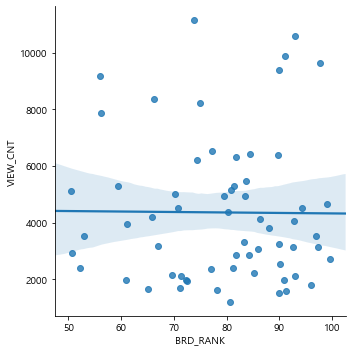

In [25]:
# 브랜드 랭킹에 따른 조회수 시각화 :  RANK : 50 - 100
sns.lmplot(x = "BRD_RANK", y = "VIEW_CNT", data = Total_V3)

In [26]:
# PUR_CNT 0인거 제외시키기
Total_Z = Total.loc[Total["PUR_CNT"] != 0]
Total_Z.dropna(inplace=True)

Total_Z.sort_values(by="BRD_RANK", ascending=True)


C:\ana\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
75,musinsastandard,1.00,MUSINSA STANDARD,9669.08,156338.74
8,adidas,3.29,ADIDAS,7218.45,47717.26
80,nike,5.43,NIKE,2392.77,305.66
116,vans,7.29,VANS,3303.52,148548.89
31,drawfit,7.57,DRAW FIT,7989.70,485.22
...,...,...,...,...,...
69,mignonneuf,97.00,MIGNONNEUF,3518.96,573.11
115,urbanstoff,97.25,URBANSTOFF,3144.63,194.43
10,ambler,97.75,AMBLER,9642.61,650.56
1,2365,99.00,23.65,4660.57,835.71


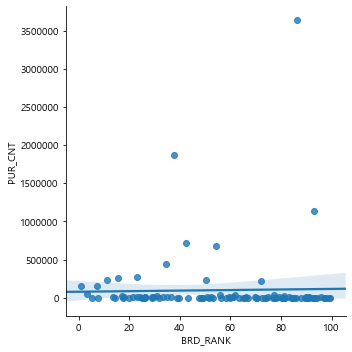

In [27]:
# 브랜드 랭킹에 따른 판매량 시각화
sns.lmplot(x = "BRD_RANK", y = "PUR_CNT", data = Total_Z)

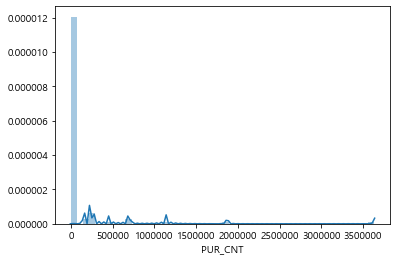

In [28]:
# 브랜드 랭킹에 따른 판매량 시각화 : 정규분포
sns.distplot(Total_Z["PUR_CNT"])

In [32]:
# 정규분포 보고 버릴건 버리자 버리자 : PUR_CNT : 3500000 -> 20000
Total_P = Total.loc[(Total["PUR_CNT"] < 13000) & (Total["PUR_CNT"] > 500)]
Total_P.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
16,brenson,13.57,BRENSON,40252.00,3840.50
19,carhartt,14.57,CARHARTT,3063.99,1775.77
113,uniformbridge,19.86,UNIFORM BRIDGE,4065.42,2342.89
37,fatalism,21.57,FATALISM,10367.58,3092.00
99,sevenselah,23.00,SEVENSELAH,9977.80,5809.27


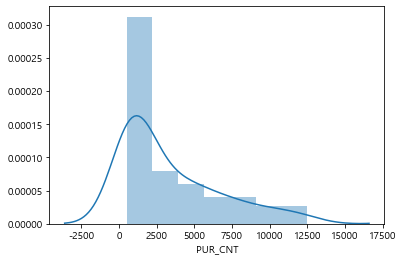

In [33]:
# 브랜드 랭킹에 따른 판매량 시각화 : 정규분포
sns.distplot(Total_P["PUR_CNT"])

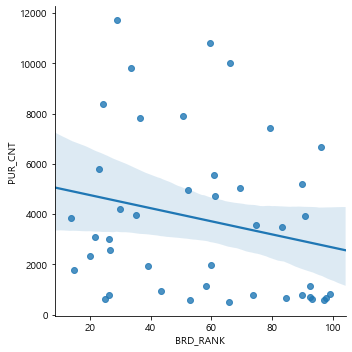

In [34]:
# 브랜드 랭킹에 따른 판매량 시각화 : PUR_CNT : 3500000 -> 13000
sns.lmplot(x = "BRD_RANK", y = "PUR_CNT", data = Total_P)

In [35]:
# 랭킹 구간별로 나눠보기 : RANK : 0 - 50
Total_P2 = Total_P.loc[Total_P["BRD_RANK"] < 50]
Total_P2.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
16,brenson,13.57,BRENSON,40252.00,3840.50
19,carhartt,14.57,CARHARTT,3063.99,1775.77
113,uniformbridge,19.86,UNIFORM BRIDGE,4065.42,2342.89
37,fatalism,21.57,FATALISM,10367.58,3092.00
99,sevenselah,23.00,SEVENSELAH,9977.80,5809.27


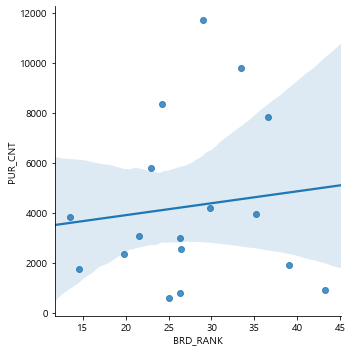

In [36]:
# 브랜드 랭킹에 따른 조회수 시각화 :  RANK : 0 - 50
sns.lmplot(x = "BRD_RANK", y = "PUR_CNT", data = Total_P2)

In [37]:
# 랭킹 구간별로 나눠보기 : RANK : 50 - 100
Total_P3 = Total_P.loc[Total_P["BRD_RANK"] >= 50]
Total_P3.sort_values(by="BRD_RANK", ascending=True).head(5)

,BRD_CODE,BRD_RANK,BRD_NAME,VIEW_CNT,PUR_CNT
94,romanticcrown,50.71,ROMANTIC CROWN,2945.82,7906.30
111,twn,52.29,TWN,2386.03,4962.28
70,minav,53.00,MINAV,3542.14,599.17
27,customade,58.14,CUSTOMADE,13112.64,1126.00
64,mahagrid,59.43,MAHAGRID,5287.58,10805.28


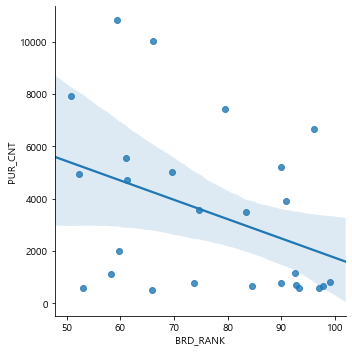

In [38]:
# 브랜드 랭킹에 따른 조회수 시각화 :  RANK : 50 - 100
sns.lmplot(x = "BRD_RANK", y = "PUR_CNT", data = Total_P3)

### 최종 결론

    브랜드 랭킹이 높으면 구매수가 높음을 알 수 있음
    하지만 브랜드 랭킹이 높기에 구매수가 높은건지
    구매수가 높기에 브랜드 랭킹이 높은건지
    어떤 것이 원인이고 결과인지 우리가 가지고있는 자료만 가지고서는 한계가 있음